<a href="https://colab.research.google.com/github/tocom242242/simclr_mnist/blob/main/simclr_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

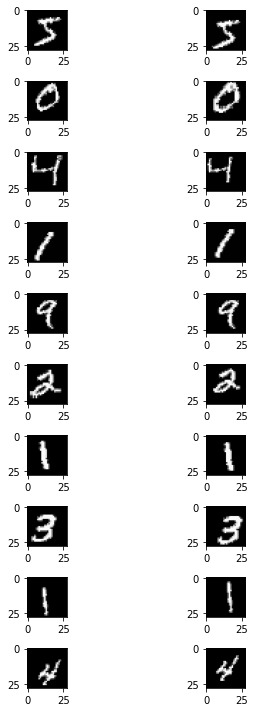

In [18]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image, ImageDraw, ImageOps
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST
import torch.optim as optim


max_epoch = 20
batch_size = 200

transform = transforms.Compose(
    [
     transforms.RandomAffine(
        degrees=[-1, 1], translate=(0.1, 0.1), scale=(0.9, 1.1)
    ),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))
     ])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])


class MNISTPair(MNIST):
    def __getitem__(self, idx):
        img, target = self.data[idx], self.targets[idx]
        img = torchvision.transforms.functional.to_pil_image(img)
        img1 = self.transform(img)
        img2 = self.transform(img)
        sample ={}
        sample["image1"] = img1
        sample["image2"] = img2
        sample["target"] = target
        return sample

trainset = MNISTPair(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)

train_loader = torch.utils.data.DataLoader(trainset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, 
                                            batch_size=batch_size,
                                            shuffle=False, 
                                            num_workers=2)


def plot_ds(dataset, row=10, col=2, figsize=(20,10)):
    fig_img, ax_img = plt.subplots(row, col, figsize=figsize, tight_layout=True)
    plt.figure()
    for i in range(row):
        sample = dataset[i]
        img1 = sample["image1"]
        img2 = sample["image2"]
        img1 = denormalization(img1.cpu().detach().numpy())
        img1 = np.squeeze(img1)
        ax_img[i][0].imshow(img1, cmap="gray")
        img2 = denormalization(img2.cpu().detach().numpy())
        img2 = np.squeeze(img2)
        ax_img[i][1].imshow(img2, cmap="gray")
        
    fig_img.savefig("data_sample.png", dpi=100)
    plt.close()

def denormalization(x):
    x = (x.transpose(1, 2, 0) * 255.0).astype(np.uint8)

    return x


plot_ds(trainset)

In [19]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [20]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


running_loss = AverageMeter("running_loss")

class Model(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Model, self).__init__()
        self.latent_dim = latent_dim
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=16,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=8,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.Flatten()
        )

        self.proj1 = nn.Sequential(
            nn.Linear(128, 50),
            nn.ReLU(True),
            nn.Linear(50, self.latent_dim),
        )
        

    def forward(self, x):
        z = self.backbone(x)
        z = self.proj1(z)
        return z


def contrastive_loss(out_1, out_2):
    out_1 = F.normalize(out_1, dim=-1)
    out_2 = F.normalize(out_2, dim=-1)
    bs = out_1.size(0)
    temp = 0.25
    # [2*B, D]
    out = torch.cat([out_1, out_2], dim=0)
    # [2*B, 2*B]
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temp)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * bs, device=sim_matrix.device)).bool()
    # [2B, 2B-1]
    sim_matrix = sim_matrix.masked_select(mask).view(2 * bs, -1)

    # compute loss
    pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temp)
    # [2*B]
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()
    return loss

def fit(model, train_loader, test_loader):

    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    # todo checkpoint 
    for epoch in range(max_epoch):
        for i, data in enumerate(train_loader):
            
            optimizer.zero_grad()
            image1 = data["image1"].to(device)
            image2 = data["image2"].to(device)
            x1 = model(image1)
            x2 = model(image2)
            loss = contrastive_loss(x1, x2)
            running_loss.update(float(loss.data))
            loss.backward()
            optimizer.step()

        print("[epoch :{:.1f} loss: {} ] ".format(epoch, running_loss.avg))
        
    return model




In [21]:
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:

import faiss
def topk_acc(targets, features, topk=1):
    # mine the topk nearest neighbors for every sample
    n, dim = features.shape[0], features.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(features)
    distances, indices = index.search(features, topk+1) # Sample itself is included
    
    # evaluate 
    neighbor_targets = np.take(targets, indices[:,1:], axis=0) # Exclude sample itself for eval
    anchor_targets = np.repeat(targets.reshape(-1,1), topk, axis=1)
    accuracy = np.mean(neighbor_targets == anchor_targets)
    return indices, accuracy

In [23]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot  as plt


def plot_scatter(x_test,y_test):
    scatter_x = x_test[:, 0]
    scatter_y = x_test[:, 1]
    

    fig, ax = plt.subplots()
    for g in np.unique(y_test):
        ix = np.where(y_test == g)
        ax.scatter(scatter_x[ix], scatter_y[ix],  label = g, s = 10)
    plt.legend()



def eval_and_plot_features(model, device, data_loader):
    model.to(device)
    feature_space = []
    labels = []
    with torch.no_grad():
        for (imgs, label) in tqdm(data_loader, desc='feature extracting'):
            imgs = imgs.to(device)
            features = model(imgs)
            feature_space.append(features)
            labels.append(label)
        feature_space = torch.cat(feature_space, dim=0).contiguous().cpu().numpy()
        labels = torch.cat(labels, dim=0).cpu().numpy()
    print("acc top 1:",topk_acc(labels, feature_space, 1)[1])
    print("acc top 5:",topk_acc(labels, feature_space, 5)[1])
    X_reduced_test = TSNE(n_components=2, random_state=0).fit_transform(feature_space)
    plot_scatter(X_reduced_test,labels)

feature extracting: 100%|██████████| 50/50 [00:01<00:00, 31.80it/s]


acc top 1: 0.098
acc top 5: 0.09868


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


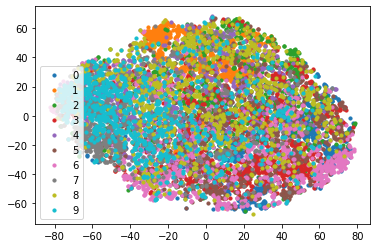

In [24]:
model = Model(13)
model.eval()
eval_and_plot_features(model, device, test_loader)

In [25]:
model.train()
model = fit(model, train_loader, test_loader)

[epoch :0.0 loss: 3.663645610809326 ] 
[epoch :1.0 loss: 3.386181434790293 ] 
[epoch :2.0 loss: 3.257020885679457 ] 
[epoch :3.0 loss: 3.179962756037712 ] 
[epoch :4.0 loss: 3.126352787812551 ] 
[epoch :5.0 loss: 3.0846406882339052 ] 
[epoch :6.0 loss: 3.0509556329818 ] 
[epoch :7.0 loss: 3.024030726154645 ] 
[epoch :8.0 loss: 3.0018708123101128 ] 
[epoch :9.0 loss: 2.983909430503845 ] 
[epoch :10.0 loss: 2.9686580204963686 ] 
[epoch :11.0 loss: 2.955619594520993 ] 
[epoch :12.0 loss: 2.9444030830187677 ] 
[epoch :13.0 loss: 2.934619846457527 ] 
[epoch :14.0 loss: 2.926014094034831 ] 
[epoch :15.0 loss: 2.9182277331749598 ] 
[epoch :16.0 loss: 2.911231866677602 ] 
[epoch :17.0 loss: 2.904888327254189 ] 
[epoch :18.0 loss: 2.8991376110545377 ] 
[epoch :19.0 loss: 2.893928197224935 ] 


feature extracting: 100%|██████████| 50/50 [00:01<00:00, 34.04it/s]


acc top 1: 0.7155
acc top 5: 0.70358


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


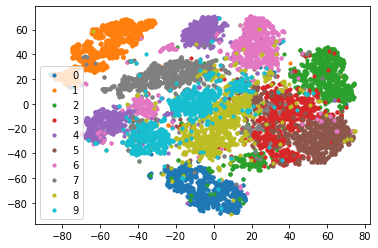

In [26]:

eval_and_plot_features(model, device, test_loader)